# Example 2 - Plotting OOI Time Series Data (from NetCDF files)
*Written by Sage Lichtenwalner, Rutgers University, June 7, 2018, with help from Friedrich Knuth*

*Verified by Leila Belabbassi (to work with Pangeo), July 9, 2018*

In this example we show how to programmatically download and work with NetCDF time series data from the OOI.  

We will use the data files created using Example 1, so please refer to that example first to find out how to request a specific dataset.

For reference, we will be using the [30m CTD on Global Papa Flanking Mooring B](http://ooi.visualocean.net/instruments/view/GP03FLMB-RIM01-02-CTDMOG060).

## Loading xarray
Before we get started, we first need to install and load the xarray library into Google Colab.

In [1]:
import xarray as xr

## The dataset 
In the previous example, we made an **Asynchronous** data request using the OOI API. We then received a two different URLs where the resulting data files can be found, a THREDDS version and a regular web site link.

Whenever you make a download request, whether you use the data portal or the API, you should also receive an email with the links in case you forgot to save them when you made the request.

In Example 1, the first URL was to the THREDDS catalog version of our dataset, which is what we'll need.  For reference, here is the [link](https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180614T193502-GP03FLMB-RIM01-02-CTDMOG060-telemetered-ctdmo_ghqr_sio_mule_instrument/catalog.html).

## Loading a single NetCDF data file

In Example 1, we requested 2 years of data (from 7/1/2015 to 7/1/2016).  This resulted in a number of files in the output directory, but only 2 key NetCDF (.nc) data files.  

*By default, the system will break up data files into individual deployments.  It will also break up the deployments if the files are larger than ~500MB.*

If we only want to load a **single NetCDF data file** (perhaps we only want one deployment or we only have one file), we could easily load it by specifying the direct link to the `.nc` file.  

To choose a single deployment file from the THREDDS catalog...
* click on the deployment/file you wish to use 
* then click on the "OPENDAP" link
* and then copy the "Data URL" from the text box.

We'll add that link here as a variable.

In [2]:
single_file = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180615T033324-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0003_GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20150701T000001-20160703T183001.nc'

We can now easily load this file using xarray.

In [3]:
# Load the data files
ds = xr.open_dataset(single_file)

# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'})

ds 

<xarray.Dataset>
Dimensions:                                  (time: 35403)
Coordinates:
    obs                                      (time) int32 0 1 2 3 4 5 6 7 8 ...
  * time                                     (time) datetime64[ns] 2015-07-01T00:00:01 ...
    pressure                                 (time) float64 ...
    lat                                      (time) float64 ...
    lon                                      (time) float64 ...
Data variables:
    deployment                               (time) int32 ...
    id                                       (time) |S64 ...
    conductivity                             (time) float64 ...
    ctd_time                                 (time) datetime64[ns] ...
    driver_timestamp                         (time) datetime64[ns] ...
    inductive_id                             (time) float32 ...
    ingestion_timestamp                      (time) datetime64[ns] ...
    internal_timestamp                       (time) datetime64[ns] .

## Plotting Timeseries Data
And now we can easily use the built in matplotlib plotting routines in xarray to make a plot.

In [4]:
ds['ctdmo_seawater_temperature'].plot();

We can also quickly make a histogram.

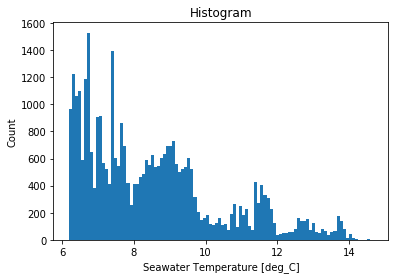

In [5]:
ds['ctdmo_seawater_temperature'].plot.hist(bins=100);

As we can plot a bunch of variables at once.

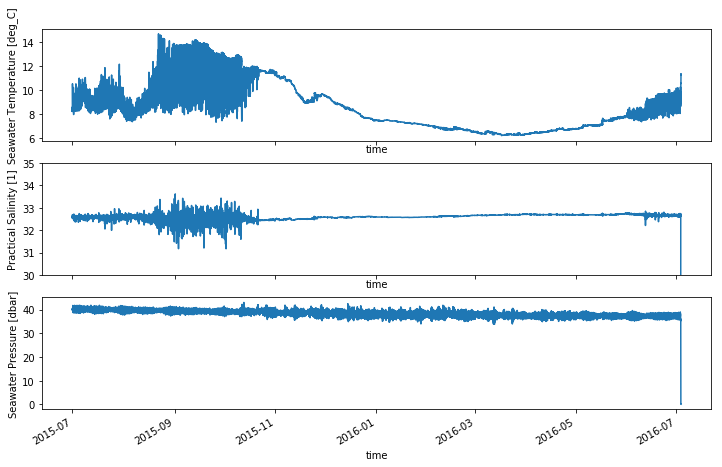

In [7]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,7))
ds['ctdmo_seawater_temperature'].plot(ax=ax1)
ds['practical_salinity'].plot(ax=ax2)
ds['ctdmo_seawater_pressure'].plot(ax=ax3);
ax2.set_ylim(30,35);

## Loading and concatenating multiple files

In [8]:
import requests
import os
import re
import pandas as pd

We can also concatenate multiple .nc files using xarray.  First we need to build up a list of all of the files we wish to include.  To start, let's specify the THREDDS url which contains all of our data files.

In [9]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180615T033324-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'


Next, we can use the following code to automatically find all of the available .nc files in the directory.  

In [10]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180615T033324-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0004_GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20160704T231501-20170630T234501.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180615T033324-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0003_GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20150701T000001-20160703T183001.nc']

(Note, when requesting data from some instruments, you will actually get data files from multiple instruments, when they are needed to calculate derived parameters.  If this happens, you will need to modify the code above or tweak the resultant list to make sure you only include .nc files from the instrument you are interested in.)

Now we can use `open_mfdataset()` to load all files into a single xarray dataset.

In [11]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                                  (time: 70062)
Coordinates:
    obs                                      (time) int64 dask.array<shape=(70062,), chunksize=(70062,)>
  * time                                     (time) datetime64[ns] 2015-07-01T00:00:01 ...
    pressure                                 (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lat                                      (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lon                                      (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
Data variables:
    deployment                               (time) int32 dask.array<shape=(70062,), chunksize=(70062,)>
    id                                       (time) |S64 dask.array<shape=(70062,), chunksize=(70062,)>
    conductivity                             (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    ctd_time                                 (time) datetime64

And now a plot of this larger dataset.

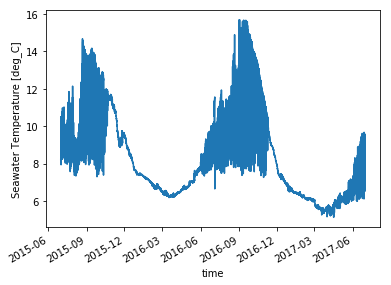

In [12]:
ds['ctdmo_seawater_temperature'].plot();

And now all the plots again.

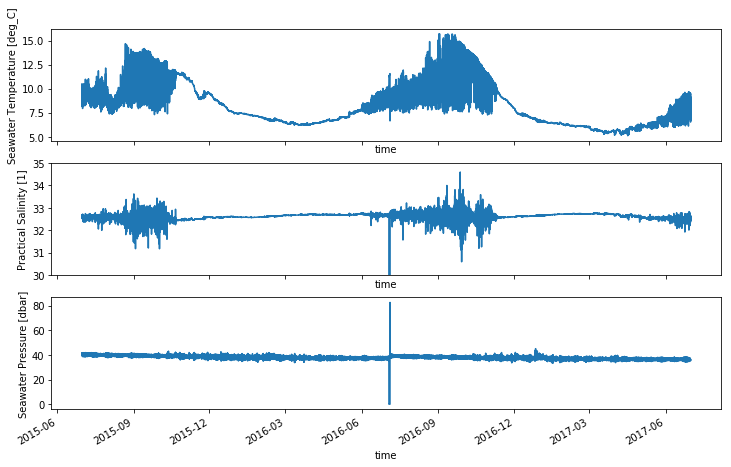

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,7))
ds['ctdmo_seawater_temperature'].plot(ax=ax1)
ds['practical_salinity'].plot(ax=ax2)
ds['ctdmo_seawater_pressure'].plot(ax=ax3);
ax2.set_ylim(30,35);

Let's try it again using dots instead of lines.

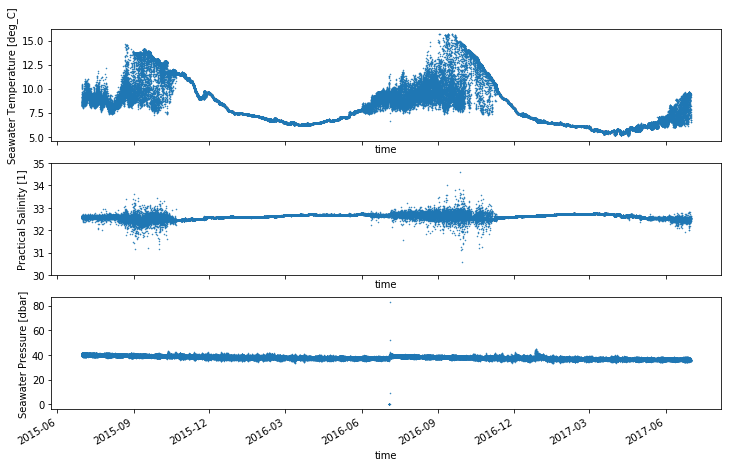

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(12,7))
ds['ctdmo_seawater_temperature'].plot(ax=ax1,linestyle='None',marker='.',markersize=1)
ds['practical_salinity'].plot(ax=ax2,linestyle='None',marker='.',markersize=1)
ds['ctdmo_seawater_pressure'].plot(ax=ax3,linestyle='None',marker='.',markersize=1);
ax2.set_ylim(30,35);

## Identifying the Sampling Frequency
We can use the following snippet of code to find out the typical sampling frequency of the dataset.  Note, this may take a while to calculate.

In [15]:
import pandas as pd
df = ds.to_dataframe()
res = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
res

0 days 00:15:00    70022
0 days 00:14:59       19
0 days 00:15:01       19
1 days 04:45:00        1
Name: time, dtype: int64

## Investigating Metadata (variable and attribute selection)
Thanks to xarray, we can easily access the global metadata as well as the metadata for individual variables.  You can refer to the full list of variables an attributes outputted above.

Here are a few examples.

In [16]:
ds.source

'GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered'

In [17]:
'%s-%s-%s' % (ds.subsite,ds.node,ds.sensor)

'GP03FLMB-RIM01-02-CTDMOG060'

In [18]:
ds['ctdmo_seawater_pressure']

<xarray.DataArray 'ctdmo_seawater_pressure' (time: 70062)>
dask.array<shape=(70062,), dtype=float64, chunksize=(70062,)>
Coordinates:
    obs       (time) int64 dask.array<shape=(70062,), chunksize=(70062,)>
  * time      (time) datetime64[ns] 2015-07-01T00:00:01 2015-07-01T00:15:01 ...
    pressure  (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lat       (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lon       (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
Attributes:
    comment:                  Seawater Pressure refers to the pressure exerte...
    long_name:                Seawater Pressure
    data_product_identifier:  PRESWAT_L1
    standard_name:            sea_water_pressure
    units:                    dbar
    ancillary_variables:      pressure,pressure_temp
    _ChunkSizes:              10000

In [19]:
import textwrap
textwrap.wrap(ds['ctdmo_seawater_pressure'].comment)

['Seawater Pressure refers to the pressure exerted on a sensor in situ',
 'by the weight of the column of seawater above it. It is calculated by',
 'subtracting one standard atmosphere from the absolute pressure at the',
 'sensor to remove the weight of the atmosphere on top of the water',
 'column. The pressure at a sensor in situ provides a metric of the',
 'depth of that sensor. Units: dbar']

In [20]:
ds['ctdmo_seawater_pressure'].dims

('time',)

In [21]:
ds['ctdmo_seawater_pressure'].coords

Coordinates:
    obs       (time) int64 dask.array<shape=(70062,), chunksize=(70062,)>
  * time      (time) datetime64[ns] 2015-07-01T00:00:01 2015-07-01T00:15:01 ...
    pressure  (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lat       (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>
    lon       (time) float64 dask.array<shape=(70062,), chunksize=(70062,)>

In [22]:
ds['ctdmo_seawater_pressure'].coords['pressure'].units

'counts'

## Some quick statistics
We can convert the **xarray Dataset** into a **padas Dataframe** to do some quick statistical calculations.


In [23]:
df = ds[['ctdmo_seawater_temperature','practical_salinity','ctdmo_seawater_pressure']].to_dataframe()
df = df.drop(columns=['pressure','obs']) #Drop unnecessary columns
df.head()

,ctdmo_seawater_temperature,practical_salinity,ctdmo_seawater_pressure,lat,lon
time,,,,,
2015-07-01 00:00:01,8.208680,32.617270,40.327935,50.33033,-144.39833
2015-07-01 00:15:01,8.248308,32.612646,40.306446,50.33033,-144.39833
2015-07-01 00:30:01,8.183896,32.624902,40.217874,50.33033,-144.39833
2015-07-01 00:45:01,8.230849,32.600060,40.168757,50.33033,-144.39833
2015-07-01 01:00:01,8.260256,32.595448,39.808679,50.33033,-144.39833


In [24]:
# Prepare to be blown away...
df.describe()

,ctdmo_seawater_temperature,practical_salinity,ctdmo_seawater_pressure,lat,lon
count,70062.000000,70062.000000,70062.000000,70062.000000,70062.000000
mean,8.233888,32.608541,37.894955,50.329796,-144.398167
std,2.097624,0.514623,1.455544,0.000540,0.000165
min,5.117477,0.000000,0.027660,50.329250,-144.398330
25%,6.497150,32.557107,36.943688,50.329250,-144.398330
50%,7.739676,32.623991,37.832048,50.330330,-144.398330
75%,9.381885,32.695673,38.832493,50.330330,-144.398000
max,15.698556,34.598292,82.486070,50.330330,-144.398000


## Downsampling
We can also easily calculate hourly, daily and monthly averages.  See the pandas [`resample()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) doc for more, as well as this list of [offset options](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases).

That said, if you want to use centered averaging, moving averages, or other more complicated averaging or filtering routines using irregular intervals, you might have to roll-your-own code.

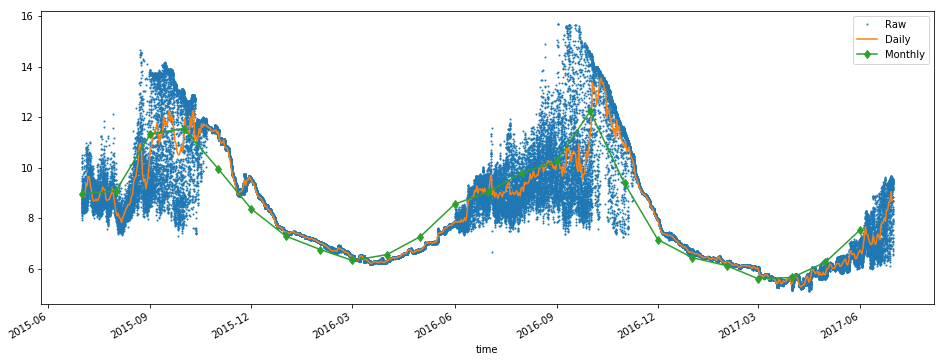

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
df['ctdmo_seawater_temperature'].plot(ax=ax,label='Raw',linestyle='None',marker='.',markersize=2)
df['ctdmo_seawater_temperature'].resample('D').mean().plot(ax=ax,label='Daily')
df['ctdmo_seawater_temperature'].resample('MS').mean().plot(ax=ax,label='Monthly',marker='d')
plt.legend();

## Creating and downloading a CSV file
Above we converted our xarray Dataset into a pandas Dataframe.  Xarray is great for loading and exporting netcdf data, while Pandas is great for doing the same with CSV.

Now that we have our data in a pandas Data frame, we can easily use the `.to_csv()` method to create a CSV file.

In [29]:
df.to_csv('output.csv') # Create the CSV file

In [28]:
# to compress the file use:
#!gzip output.csv

In [27]:
ls -l

total 9412
-rw-r--r-- 1 jovyan users   21997 Jul  9 19:43 Example_1_Requesting_OOI_Data.ipynb
-rw-r--r-- 1 jovyan users  665070 Jul  9 20:14 Example_2_Plotting_OOI_Timeseries_Data.ipynb
-rw-r--r-- 1 jovyan users 1321545 Jul  9 19:33 Example_3_DO_Profiles.ipynb
drwxrwsr-x 9 jovyan users    4096 Jul  9 19:33 extras/
-rw-r--r-- 1 jovyan users  760162 Jul  9 19:33 OOI_Example_Data_Quality_Report.ipynb
-rw-r--r-- 1 jovyan users 6552593 Jul  9 20:15 output.csv
-rw-rw-r-- 1 jovyan users    6978 Jul  5 23:47 quickstart_matlab.m
-rw-rw-r-- 1 jovyan users  280019 Jul  5 23:47 quickstart.png
-rw-rw-r-- 1 jovyan users    8290 Jul  5 23:47 quickstart_r.R


## Bokeh Plots
Finally, let's create an interactive plot using the Bokeh library.

In [30]:
# Import Bokeh functions
import os
from bokeh.plotting import figure, output_file, reset_output, show, ColumnDataSource, save
from bokeh.layouts import column
from bokeh.models import BoxAnnotation
from bokeh.io import output_notebook

In [31]:
# Let's downsample temperature a big
ds2 = ds['ctdmo_seawater_temperature'][0::10] #Start/Stop/Stride
ds2

<xarray.DataArray 'ctdmo_seawater_temperature' (time: 7007)>
dask.array<shape=(7007,), dtype=float64, chunksize=(7007,)>
Coordinates:
    obs       (time) int64 dask.array<shape=(7007,), chunksize=(7007,)>
  * time      (time) datetime64[ns] 2015-07-01T00:00:01 2015-07-01T02:30:01 ...
    pressure  (time) float64 dask.array<shape=(7007,), chunksize=(7007,)>
    lat       (time) float64 dask.array<shape=(7007,), chunksize=(7007,)>
    lon       (time) float64 dask.array<shape=(7007,), chunksize=(7007,)>
Attributes:
    comment:                  Seawater temperature near the sensor. Units: de...
    long_name:                Seawater Temperature
    precision:                4
    data_product_identifier:  TEMPWAT_L1
    standard_name:            sea_water_temperature
    units:                    deg_C
    ancillary_variables:      temperature
    _ChunkSizes:              10000

In [32]:
source = ColumnDataSource(
    data=dict(
        x=list(ds2.time.values),
        y=list((ds2.values*-1))
    )
)

s = figure(width=800,
           height=400,
           title='Global Papa Flanking Subsurface Mooring B Mooring Riser CTD (30 m)',
           x_axis_label='Time (GMT)',
           y_axis_label='Temperature (C)',
           x_axis_type='datetime')

# s.line('x', 'y', line_width=3, source=source)
s.circle('x', 'y', fill_color='white', size=4, source=source)

output_notebook()
show(column(s))

# output_file(os.getcwd())
# save(s, filename='pressure.html')

Loading BokehJS ...

So that's the quick tour of some of the things you can do in Python with OOI timeseries datasets.  In Example 3, we will show you some additional tricks to use when working with vertical profiler or glider data.